# 2017 QHP Individual Market Dental Insurance

Data from [healthcare.gov](https://data.healthcare.gov/dataset/2017-QHP-Landscape-Individual-Market-Dental/gwq7-ribq). 

# Upload Data

In [2]:
# upload csv
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 2017_QHP_Landscape_Individual_Market_Dental.csv to 2017_QHP_Landscape_Individual_Market_Dental.csv
User uploaded file "2017_QHP_Landscape_Individual_Market_Dental.csv" with length 31184456 bytes


In [1]:
# upload population data
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving US_Population_Density_by_State.csv to US_Population_Density_by_State.csv
User uploaded file "US_Population_Density_by_State.csv" with length 2161 bytes


In [3]:
!ls

2017_QHP_Landscape_Individual_Market_Dental.csv
sample_data
US_Population_Density_by_State.csv


# Imports and Load Data

In [4]:
# standard libraries
import pandas as pd
import numpy as np
import os

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
from vega_datasets import data

# train-test split
from sklearn.model_selection import train_test_split

# linear regression models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor

# cross val, k-folds, scaler
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

# suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# ignore warnings
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.filterwarnings("ignore", category=Warning)
print('Warnings will be ignored!')

Warnings will be ignored!


# Population Stats

In [0]:
# population stats df
pop_df = pd.read_csv('US_Population_Density_by_State.csv')
pop_df.columns = ['State', 'State Code', 'StateID_Geo', 'Pop Density', 'Population', 'Area']

pop_df['Pop Density'] = pop_df['Pop Density'].str.replace(',', '')
pop_df['Pop Density'] = pop_df['Pop Density'].astype('uint32')

pop_df['Population'] = pop_df['Population'].str.replace(',', '')
pop_df['Population'] = pop_df['Population'].astype('uint32')

pop_df['Area'] = pop_df['Area'].str.replace(',', '')
pop_df['Area'] = pop_df['Area'].astype('uint32')

# pop_df['StateID'] = pop_df['State Code'].map(state_dict).fillna(39).astype('uint16')
# pop_df = pop_df.drop(['State Code'], axis=1)

# Data Cleaning + Feature Engineering

In [0]:
# load data
df = pd.read_csv('2017_QHP_Landscape_Individual_Market_Dental.csv')

# remove child only offerings
df = df[df['Child Only Offering'] == 'Allows Adult and Child-Only']

# encode state names by frequency
state_list = df['State Code'].value_counts().index.tolist()

state_dict = dict()
for x in range(0, (len(state_list))):
    state_dict[state_list[x]] = x
      
df['StateID'] = df['State Code'].map(state_dict).astype('uint8')

# state value counts
df['StateFreq'] = df['State Code'].map(df['State Code'].value_counts())

# merge with population data
df = pd.merge(df, pop_df, on='State Code')

# drop features with all nulls and unneeded features
df = df.drop(['Premium Rates', 'Standard On Exchange', 'Child Only Offering'], axis=1)

# drop phone number features
df = df.drop(['Customer Service Phone Number Local', 'Customer Service Phone Number Toll Free', 
             'Customer Service Phone Number TTY'], axis=1)

# reset index
df = df.reset_index(drop=True)

# county changed to county + state code
df['County Name'] = df['County Name'] + " " + df['State Code']

# encode county names by frequency
county_list = df['County Name'].value_counts().index.tolist()

county_dict = dict()
for x in range(0, (len(county_list))):
    county_dict[county_list[x]] = x
    
df['CountyID'] = df['County Name'].map(county_dict).astype('uint16')

# encode issuers by frequency
issuer_list = df['Issuer Name'].value_counts().index.tolist()

issuer_dict = dict()
for x in range(0, (len(issuer_list))):
    issuer_dict[issuer_list[x]] = x
    
df['IssuerID'] = df['Issuer Name'].map(issuer_dict).astype('uint16')

# encode marketing plans
marketing_plan_list = df['Plan Marketing Name']

marekting_plan_dict = dict()
for x in range(0, (len(marketing_plan_list))):
    marekting_plan_dict[marketing_plan_list[x]] = x
    
df['PlanMarketingID'] = df['Plan Marketing Name'].map(marekting_plan_dict).astype('uint16')

# encode plan IDs
plan_id_list = df['Plan ID (Standard Component)']

plan_id_dict = dict()
for x in range(0, (len(plan_id_list))):
    plan_id_dict[plan_id_list[x]] = x
    
df['PlanID Encoded'] = df['Plan ID (Standard Component)'].map(plan_id_dict).astype('uint16')

# 'Metal Level' turned into binomial
# considering changing name to 'Hi Metal Level'
df['Metal Level'] = df['Metal Level'].replace('Low', 0)
df['Metal Level'] = df['Metal Level'].replace('High', 1)
df['Metal Level'] = df['Metal Level'].astype('uint8')

# turn 'Rating Area' into numeric value
df['Rating Area'] = df['Rating Area'].str.replace('Rating Area ', '').astype('uint16')

# replace nulls in coverage categories
df['Routine Dental Services - Adult (Coverage)'] = df['Routine Dental Services - Adult (Coverage)'].fillna(0)
df['Basic Dental Care - Adult (Coverage)'] = df['Basic Dental Care - Adult (Coverage)'].fillna(0)
df['Major Dental Care - Adult (Coverage)'] = df['Major Dental Care - Adult (Coverage)'].fillna(0)
df['Orthodontia - Adult (Coverage)'] = df['Orthodontia - Adult (Coverage)'].fillna(0)
df['Dental Check-Up for Children (Coverage)'] = df['Dental Check-Up for Children (Coverage)'].fillna(0)
df['Basic Dental Care - Child (Coverage)'] = df['Basic Dental Care - Child (Coverage)'].fillna(0)
df['Major Dental Care - Child (Coverage)'] = df['Major Dental Care - Child (Coverage)'].fillna(0)
df['Orthodontia - Child (Coverage)'] = df['Orthodontia - Child (Coverage)'].fillna(0)

# turn coverage categories into binomials
df['Routine Dental Services - Adult (Coverage)'] = df['Routine Dental Services - Adult (Coverage)'].replace('X', 1)
df['Basic Dental Care - Adult (Coverage)'] = df['Basic Dental Care - Adult (Coverage)'].replace('X', 1)
df['Major Dental Care - Adult (Coverage)'] = df['Major Dental Care - Adult (Coverage)'].replace('X', 1)
df['Orthodontia - Adult (Coverage)'] = df['Orthodontia - Adult (Coverage)'].replace('X', 1)
df['Dental Check-Up for Children (Coverage)'] = df['Dental Check-Up for Children (Coverage)'].replace('X', 1)
df['Basic Dental Care - Child (Coverage)'] = df['Basic Dental Care - Child (Coverage)'].replace('X', 1)
df['Major Dental Care - Child (Coverage)'] = df['Major Dental Care - Child (Coverage)'].replace('X', 1)
df['Orthodontia - Child (Coverage)'] = df['Orthodontia - Child (Coverage)'].replace('X', 1)

# convert coverage categories into 'uint8' data type
df['Routine Dental Services - Adult (Coverage)'] = df['Routine Dental Services - Adult (Coverage)'].astype('uint8')
df['Basic Dental Care - Adult (Coverage)'] = df['Basic Dental Care - Adult (Coverage)'].astype('uint8')
df['Major Dental Care - Adult (Coverage)'] = df['Major Dental Care - Adult (Coverage)'].astype('uint8')
df['Orthodontia - Adult (Coverage)'] = df['Orthodontia - Adult (Coverage)'].astype('uint8')
df['Dental Check-Up for Children (Coverage)'] = df['Dental Check-Up for Children (Coverage)'].astype('uint8')
df['Basic Dental Care - Child (Coverage)'] = df['Basic Dental Care - Child (Coverage)'].astype('uint8')
df['Major Dental Care - Child (Coverage)'] = df['Major Dental Care - Child (Coverage)'].astype('uint8')
df['Orthodontia - Child (Coverage)'] = df['Orthodontia - Child (Coverage)'].astype('uint8')

# remove dollar signs and turn into 'uint16' / impute 'Not Applicable' values with .quantile(q=0.75) 
# NA does not mean zero; it typically means multiple deductibles; so expect higher than average

df['Dental Deductible - Family (Per Person) - Standard'] = df['Dental Deductible - Family (Per Person) - Standard'].str.replace('$', '')
df['Dental Deductible - Family (Per Person) - Standard'] = df['Dental Deductible - Family (Per Person) - Standard'].str.replace(' ', '')
df['Dental Deductible - Family (Per Person) - Standard'] = pd.to_numeric(df['Dental Deductible - Family (Per Person) - Standard'], errors='coerce')
df['Dental Deductible - Family (Per Person) - Standard'] = df['Dental Deductible - Family (Per Person) - Standard'].fillna(df['Dental Deductible - Family (Per Person) - Standard'].quantile(q=0.75))
df['Dental Deductible - Family (Per Person) - Standard'] = df['Dental Deductible - Family (Per Person) - Standard'].astype('uint16')

df['Dental Deductible - Individual - Standard'] = df['Dental Deductible - Individual - Standard'].str.replace('$', '')
df['Dental Deductible - Individual - Standard'] = df['Dental Deductible - Individual - Standard'].str.replace(' ', '')
df['Dental Deductible - Individual - Standard'] = pd.to_numeric(df['Dental Deductible - Individual - Standard'], errors='coerce')
df['Dental Deductible - Individual - Standard'] = df['Dental Deductible - Individual - Standard'].fillna(df['Dental Deductible - Individual - Standard'].quantile(q=0.75))
df['Dental Deductible - Individual - Standard'] = df['Dental Deductible - Individual - Standard'].astype('uint16')

df['Dental Deductible - Family - Standard'] = df['Dental Deductible - Family - Standard'].str.replace('$', '')
df['Dental Deductible - Family - Standard'] = df['Dental Deductible - Family - Standard'].str.replace(' ', '')
df['Dental Deductible - Family - Standard'] = pd.to_numeric(df['Dental Deductible - Family - Standard'], errors='coerce')
df['Dental Deductible - Family - Standard'] = df['Dental Deductible - Family - Standard'].fillna(df['Dental Deductible - Family - Standard'].quantile(q=0.75))
df['Dental Deductible - Family - Standard'] = df['Dental Deductible - Family - Standard'].astype('uint16')

df['Dental Maximum Out of Pocket - Individual - Standard'] = df['Dental Maximum Out of Pocket - Individual - Standard'].str.replace('$', '')
df['Dental Maximum Out of Pocket - Individual - Standard'] = df['Dental Maximum Out of Pocket - Individual - Standard'].str.replace(' ', '')
df['Dental Maximum Out of Pocket - Individual - Standard'] = df['Dental Maximum Out of Pocket - Individual - Standard'].astype('uint16')

df['Dental Maximum Out of Pocket - Family - Standard'] = df['Dental Maximum Out of Pocket - Family - Standard'].str.replace('$', '')
df['Dental Maximum Out of Pocket - Family - Standard'] = df['Dental Maximum Out of Pocket - Family - Standard'].str.replace(' ', '')
df['Dental Maximum Out of Pocket - Family - Standard'] = df['Dental Maximum Out of Pocket - Family - Standard'].astype('uint16')

df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'] = df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'].str.replace('$', '')
df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'] = df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'].str.replace(' ', '')
df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'] = pd.to_numeric(df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'], errors='coerce')
df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'] = df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'].fillna(0)
df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'] = df['Dental Maximum Out of Pocket - Family (Per Person) - Standard'].astype('uint16')

# turn 'Source' into binomial
df['SERFF'] = df['Source']
df['SERFF'] = df['SERFF'].replace('HIOS', 0)
df['SERFF'] = df['SERFF'].replace('SERFF', 1)
df['SERFF'] = df['SERFF'].astype('uint8')

# create average premium per person metric as sum of all premiums divided by estimated # of individuals
df['Avg Premium'] = df[['Premium Child','Premium Adult Individual Age 21', 'Premium Adult Individual Age 27',
       'Premium Adult Individual Age 30 ', 'Premium Adult Individual Age 40 ',
       'Premium Adult Individual Age 50 ', 'Premium Adult Individual Age 60 ',
       'Premium Couple 21  ', 'Premium Couple 30 ', 'Premium Couple 40 ',
       'Premium Couple 50 ', 'Premium Couple 60 ', 'Couple+1 child, Age 21',
       'Couple+1 child, Age 30 ', 'Couple+1 child, Age 40 ',
       'Couple+1 child, Age 50 ', 'Couple+2 children, Age 21',
       'Couple+2 children, Age 30 ', 'Couple+2 children, Age 40 ',
       'Couple+2 children, Age 50', 'Couple+3 or more Children, Age 21',
       'Couple+3 or more Children, Age 30',
       'Couple+3 or more Children, Age 40',
       'Couple+3 or more Children, Age 50', 'Individual+1 child, Age 21',
       'Individual+1 child, Age 30', 'Individual+1 child, Age 40',
       'Individual+1 child, Age 50', 'Individual+2 children, Age 21',
       'Individual+2 children, Age 30', 'Individual+2 children, Age 40',
       'Individual+2 children, Age 50',
       'Individual+3 or more children, Age 21',
       'Individual+3 or more children, Age 30',
       'Individual+3 or more children, Age 40',
       'Individual+3 or more children, Age 50',]].sum(axis = 1, skipna = True) / 101

# insurance plans per capita; measure of competition
df['PlansPer100K'] = (df['StateFreq'] / df['Population']) * 100000

def mean_premium_map(feature):
    mean_premium = df.groupby(feature, as_index=True)['Avg Premium'].mean()
    mean_premium_dict = dict(zip(mean_premium.index, mean_premium))
    return mean_premium_dict

# mean premium per provider
df['Issuer_MP'] = df['IssuerID'].map(mean_premium_map(df['IssuerID'])).astype('float32')

# mean premium by state
df['State_MP'] = df['StateID'].map(mean_premium_map(df['StateID'])).astype('float32')

# mean premium by county
df['County_MP'] = df['CountyID'].map(mean_premium_map(df['CountyID'])).astype('float32')

# mean premium by rating area
df['RatingArea_MP'] = df['Rating Area'].map(mean_premium_map(df['Rating Area'])).astype('float32')

# mean premium by plans per capita
df['PlansPer100K_MP'] = df['PlansPer100K'].map(mean_premium_map(df['PlansPer100K'])).astype('float32')

# mean premium by marketing id
df['MarketingID_MP'] = df['PlanMarketingID'].map(mean_premium_map(df['PlanMarketingID'])).astype('float32')

# mean premium by pop density
df['PopDensity_MP'] = df['Pop Density'].map(mean_premium_map(df['Pop Density'])).astype('float32')

# pop density bins
df['PopDensityBins'] = pd.qcut(df['Pop Density'], q=11, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], duplicates='drop')

# mean premium by pop density bucket
df['PopDensityBin_MP'] = df['PopDensityBins'].map(mean_premium_map(df['PopDensityBins'])).astype('float32')


# drop some redundant columns
df = df.drop(['Source'], axis=1)


In [0]:
# # print value counts for all 'objects'
# def object_vcs_and_nulls(df):
#   for i in df:
#     if df[i].dtype == 'O':
# #       if df[i].isnull().sum() > 0:
#         print(df[i].value_counts())  
#         print("Number of Null Values: " + str(df[i].isnull().sum()))
#         print("Percentage of Nulls = " + str(np.round((df[i].isnull().sum() / df.shape[0] * 100), 2)) + "%")
#         print("\n")
      
# object_vcs_and_nulls(df)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40646 entries, 0 to 40645
Data columns (total 91 columns):
State Code                                                       40646 non-null object
FIPS County Code                                                 40646 non-null int64
County Name                                                      40646 non-null object
Metal Level                                                      40646 non-null uint8
Issuer Name                                                      40646 non-null object
HIOS Issuer ID                                                   40646 non-null int64
Plan ID (Standard Component)                                     40646 non-null object
Plan Marketing Name                                              40646 non-null object
Plan Type                                                        40646 non-null object
Rating Area                                                      40646 non-null uint16
Routine Dental Services 

In [8]:
df.head()

,State Code,FIPS County Code,County Name,Metal Level,Issuer Name,HIOS Issuer ID,Plan ID (Standard Component),Plan Marketing Name,Plan Type,Rating Area,...,PlansPer100K,Issuer_MP,State_MP,County_MP,RatingArea_MP,PlansPer100K_MP,MarketingID_MP,PopDensity_MP,PopDensityBins,PopDensityBin_MP
0,AK,2013,Aleutians East AK,0,Oregon Dental Service,21989,21989AK0030001,Delta Dental Premier Plan,Indemnity,2,...,20.188,41.132,51.935,52.537,28.597,51.935,41.426,51.935,0,30.574
1,AK,2013,Aleutians East AK,1,BEST Life and Health Insurance Company,74819,74819AK0020003,BESTOne Advantage Gold,PPO,2,...,20.188,31.093,51.935,52.537,28.597,51.935,36.629,51.935,0,30.574
2,AK,2013,Aleutians East AK,1,BEST Life and Health Insurance Company,74819,74819AK0020004,BESTOne Plus Gold,PPO,2,...,20.188,31.093,51.935,52.537,28.597,51.935,33.378,51.935,0,30.574
3,AK,2013,Aleutians East AK,0,BEST Life and Health Insurance Company,74819,74819AK0020005,BESTOne Plus Silver,PPO,2,...,20.188,31.093,51.935,52.537,28.597,51.935,29.578,51.935,0,30.574
4,AK,2013,Aleutians East AK,0,BEST Life and Health Insurance Company,74819,74819AK0020006,BESTOne Basic Silver,PPO,2,...,20.188,31.093,51.935,52.537,28.597,51.935,25.335,51.935,0,30.574


# Create Visualization Dataframes

In [0]:
# function to generate new dataframes for stats
def feature_by_premium(feature):

    new_df = pd.DataFrame()
       
    avg_prem_state = df.groupby(feature, as_index=True)['Avg Premium'].mean()
    new_df['avg_prem'] = avg_prem_state
    
    new_df['id'] = new_df.index    
  
    return new_df

In [0]:
state_prem_df = feature_by_premium('StateID_Geo')

In [0]:
state_prem_df = state_prem_df.reindex(list(range(state_prem_df.index.min(),state_prem_df.index.max()+1)),fill_value=np.nan)

# Map Visualizations

* [Choropleth Maps Altair](https://www.districtdatalabs.com/altair-choropleth-viz)

In [81]:
states = alt.topo_feature(data.us_10m.url, 'states')
source = state_prem_df
variable_list = ['avg_prem']

alt.Chart(states,title='Average Premium by State').mark_geoshape().encode(
    alt.Color(alt.repeat('row'), type='quantitative', sort= "descending", scale=alt.Scale(scheme='viridis'))
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', variable_list)
).properties(
    width=500,
    height=300
).project(
    type='albersUsa'
).repeat(
    row=variable_list
).resolve_scale(
    color='independent'
)

# states = alt.topo_feature(data.us_10m.url, 'states')
# source = state_prem_df
# variable_list = ['avg_prem']

# alt.Chart(states,title='Average Premium by State').configure_title(fontSize=24).mark_geoshape().encode(
#     alt.Color(type='quantitative', sort= "descending", scale=alt.Scale(scheme='viridis'))
# ).transform_lookup(
#     lookup='id',
#     from_=alt.LookupData(source, 'id', variable_list)
# ).properties(
#     width=500,
#     height=300
# ).project(
#     type='albersUsa'
# )

RepeatChart({
  repeat: Repeat({
    row: ['avg_prem']
  }),
  resolve: Resolve({
    scale: ScaleResolveMap({
      color: 'independent'
    })
  }),
  spec: Chart({
    data: UrlData({
      format: TopoDataFormat({
        feature: 'states',
        type: 'topojson'
      }),
      url: 'https://vega.github.io/vega-datasets/data/us-10m.json'
    }),
    encoding: EncodingWithFacet({
      color: Color({
        scale: Scale({
          scheme: 'viridis'
        }),
        shorthand: RepeatRef({
          repeat: 'row'
        }),
        sort: 'descending',
        type: 'quantitative'
      })
    }),
    height: 300,
    mark: 'geoshape',
    projection: Projection({
      type: 'albersUsa'
    }),
    title: 'Average Premium by State',
    transform: [LookupTransform({
      from: LookupData({
        data:              avg_prem  id
        StateID_Geo              
        1              24.666   1
        2              51.935   2
        4              29.909   4
        5              27.296   5
        10             26.880  10
        12             23.725  12
        13             28.420  13
        17             28.225  17
        18             28.309  18
        19             31.654  19
        20             28.117  20
        21             21.986  21
        22             29.072  22
        23             32.365  23
        26             28.651  26
        28             28.022  28
        29             27.027  29
        30             39.449  30
        31             27.404  31
        32             32.105  32
        33             35.012  33
        34             31.211  34
        35             24.643  35
        37             33.107  37
        38             31.062  38
        39             25.610  39
        40             28.903  40
        41             34.966  41
        42             24.046  42
        45             27.022  45
        46             29.572  46
        47             25.248  47
        48             27.530  48
        49             26.614  49
        51             26.141  51
        54             22.755  54
        55             32.009  55
        56             33.757  56,
        fields: ['avg_prem'],
        key: 'id'
      }),
      lookup: 'id'
    })],
    width: 500
  })
})

In [12]:
states = alt.topo_feature(data.us_10m.url, 'states')
source = state_prem_df


alt.Chart(states, title="Average Dental Insurance Premium by State").configure_title(fontSize=24).mark_geoshape().encode(
    color=alt.Color('avg_prem:Q', sort="descending",  scale=alt.Scale(scheme='viridis'))
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id', ['avg_prem'])
).project(
    type='albersUsa'
).properties(
    width=700,
    height=450
)


Chart({
  config: Config({
    title: VgTitleConfig({
      fontSize: 24
    })
  }),
  data: UrlData({
    format: TopoDataFormat({
      feature: 'states',
      type: 'topojson'
    }),
    url: 'https://vega.github.io/vega-datasets/data/us-10m.json'
  }),
  encoding: EncodingWithFacet({
    color: Color({
      scale: Scale({
        scheme: 'viridis'
      }),
      shorthand: 'avg_prem:Q',
      sort: 'descending'
    })
  }),
  height: 450,
  mark: 'geoshape',
  projection: Projection({
    type: 'albersUsa'
  }),
  title: 'Average Dental Insurance Premium by State',
  transform: [LookupTransform({
    from: LookupData({
      data:              avg_prem     id
      StateID_Geo                 
      1              24.666  1.000
      2              51.935  2.000
      3                 nan    nan
      4              29.909  4.000
      5              27.296  5.000
      6                 nan    nan
      7                 nan    nan
      8                 nan    nan
      9                 nan    nan
      10             26.880 10.000
      11                nan    nan
      12             23.725 12.000
      13             28.420 13.000
      14                nan    nan
      15                nan    nan
      16                nan    nan
      17             28.225 17.000
      18             28.309 18.000
      19             31.654 19.000
      20             28.117 20.000
      21             21.986 21.000
      22             29.072 22.000
      23             32.365 23.000
      24                nan    nan
      25                nan    nan
      26             28.651 26.000
      27                nan    nan
      28             28.022 28.000
      29             27.027 29.000
      30             39.449 30.000
      31             27.404 31.000
      32             32.105 32.000
      33             35.012 33.000
      34             31.211 34.000
      35             24.643 35.000
      36                nan    nan
      37             33.107 37.000
      38             31.062 38.000
      39             25.610 39.000
      40             28.903 40.000
      41             34.966 41.000
      42             24.046 42.000
      43                nan    nan
      44                nan    nan
      45             27.022 45.000
      46             29.572 46.000
      47             25.248 47.000
      48             27.530 48.000
      49             26.614 49.000
      50                nan    nan
      51             26.141 51.000
      52                nan    nan
      53                nan    nan
      54             22.755 54.000
      55             32.009 55.000
      56             33.757 56.000,
      fields: ['avg_prem'],
      key: 'id'
    }),
    lookup: 'id'
  })],
  width: 700
})

In [15]:
# US states background
alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    title='US State Capitols',
    width=700,
    height=400
).project('albersUsa')



Chart({
  data: UrlData({
    format: TopoDataFormat({
      feature: 'states',
      type: 'topojson'
    }),
    url: 'https://vega.github.io/vega-datasets/data/us-10m.json'
  }),
  height: 400,
  mark: MarkDef({
    fill: 'lightgray',
    stroke: 'white',
    type: 'geoshape'
  }),
  projection: Projection({
    type: 'albersUsa'
  }),
  title: 'US State Capitols',
  width: 700
})

# Visualizations

In [0]:
# # function to generate new dataframes for stats
# def feature_by_premium(feature):

#     new_df = pd.DataFrame()
       
#     avg_prem_state = df.groupby(feature, as_index=True)['Avg Premium'].mean()
#     new_df['avg_prem'] = avg_prem_state
    
#     new_df['id'] = new_df.index    
  
#     return new_df

In [0]:
inv_issuer_dict = pd.Series(df['Issuer Name'].values,index=df['IssuerID']).to_dict()

In [0]:
issuer_prem_df = feature_by_premium('IssuerID')
issuer_prem_df = issuer_prem_df[:20]
issuer_prem_df['Issuer Name'] = issuer_prem_df['id'].map(inv_issuer_dict)

In [36]:
issuer_prem_df.shape

(20, 3)

In [37]:
issuer_prem_df.head()

,avg_prem,id,Issuer Name
IssuerID,,,
0,31.093,0,BEST Life and Health Insurance Company
1,32.811,1,TRUASSURE INSURANCE COMPANY
2,29.773,2,Dentegra Insurance Company
3,29.140,3,Renaissance Life & Health Insurance Company of...
4,27.380,4,Delta Dental Insurance Company


In [0]:
sns.set(style="white", context="talk")

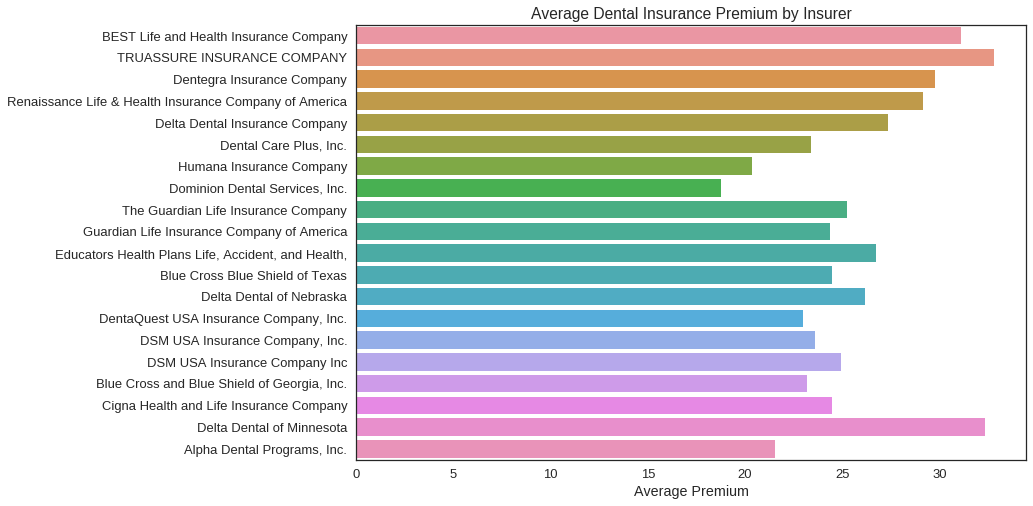

In [55]:
# # Randomly reorder the data to make it qualitative
# y3 = rs.choice(y1, len(y1), replace=False)
# sns.barplot(x=x, y=y3, palette="deep", ax=ax3)
# ax3.axhline(0, color="k", clip_on=False)
# ax3.set_ylabel("Qualitative")

# # Finalize the plot
# sns.despine(bottom=True)
# plt.setp(f.axes, yticks=[])
# plt.tight_layout(h_pad=2)


plt.figure(figsize=(12,8))
sns.barplot(y=issuer_prem_df['Issuer Name'], x='avg_prem', data=issuer_prem_df);

plt.ylabel('')
plt.xlabel('Average Premium')
plt.title('Average Dental Insurance Premium by Insurer');
# plt.xticks(rotation=90);

# sns.barplot(x=issuer_prem_df['Issuer Name'], y='avg_prem', data=issuer_prem_df);

# Models

In [0]:
# shuffle data for cross_val_score; function scores poor w/o it
shuffle_df = df.reindex(np.random.permutation(df.index))

# created modified dataframe of only numeric values
mod_df = shuffle_df._get_numeric_data()

# eliminate features with near 100% correlation with y-var
mod_df = mod_df.drop(['Premium Child',
       'Premium Adult Individual Age 21', 'Premium Adult Individual Age 27',
       'Premium Adult Individual Age 30 ', 'Premium Adult Individual Age 40 ',
       'Premium Adult Individual Age 50 ', 'Premium Adult Individual Age 60 ',
       'Premium Couple 21  ', 'Premium Couple 30 ', 'Premium Couple 40 ',
       'Premium Couple 50 ', 'Premium Couple 60 ', 'Couple+1 child, Age 21',
       'Couple+1 child, Age 30 ', 'Couple+1 child, Age 40 ',
       'Couple+1 child, Age 50 ', 'Couple+2 children, Age 21',
       'Couple+2 children, Age 30 ', 'Couple+2 children, Age 40 ',
       'Couple+2 children, Age 50', 'Couple+3 or more Children, Age 21',
       'Couple+3 or more Children, Age 30',
       'Couple+3 or more Children, Age 40',
       'Couple+3 or more Children, Age 50', 'Individual+1 child, Age 21',
       'Individual+1 child, Age 30', 'Individual+1 child, Age 40',
       'Individual+1 child, Age 50', 'Individual+2 children, Age 21',
       'Individual+2 children, Age 30', 'Individual+2 children, Age 40',
       'Individual+2 children, Age 50',
       'Individual+3 or more children, Age 21',
       'Individual+3 or more children, Age 30',
       'Individual+3 or more children, Age 40',
       'Individual+3 or more children, Age 50'], axis=1)

In [0]:
mod_df.columns

Index(['FIPS County Code', 'Metal Level', 'HIOS Issuer ID', 'Rating Area',
       'Routine Dental Services - Adult (Coverage)',
       'Basic Dental Care - Adult (Coverage)',
       'Major Dental Care - Adult (Coverage)',
       'Orthodontia - Adult (Coverage)',
       'Dental Check-Up for Children (Coverage)',
       'Basic Dental Care - Child (Coverage)',
       'Major Dental Care - Child (Coverage)',
       'Orthodontia - Child (Coverage)',
       'Dental Deductible - Individual - Standard',
       'Dental Deductible - Family - Standard',
       'Dental Deductible - Family (Per Person) - Standard',
       'Dental Maximum Out of Pocket - Individual - Standard',
       'Dental Maximum Out of Pocket - Family - Standard',
       'Dental Maximum Out of Pocket - Family (Per Person) - Standard',
       'StateID', 'StateFreq', 'Pop Density', 'Population', 'Area', 'CountyID',
       'IssuerID', 'PlanMarketingID', 'PlanID Encoded', 'SERFF', 'Avg Premium',
       'PlansPer100K'],
      dtype='

In [0]:
X = mod_df.drop(['Avg Premium'], axis=1)
y = mod_df['Avg Premium']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)

In [0]:
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_pred, y_test) : 
    if len(y_test) == len(y_pred):
        return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))
      
# Root mean squared error (RMSE)
def rmse(y_pred, y_test):
  return np.sqrt(mean_squared_error(y_test, y_pred))

In [0]:
# Linear Regression
lm = LinearRegression()
model_lm = lm.fit(X_train,y_train)
pred_lm = lm.predict(X_test)
result_lm = model_lm.score(X_test, y_test)
cv_scores_lm = cross_val_score(lm, X, y, cv=5, scoring='neg_mean_squared_log_error')
lm_rmsle = np.sqrt(np.abs(cv_scores_lm.mean()))

print("=== Linear Regression ===")
print("R2: " + str(result_lm))
print("RMSLE: " + str(rmsle(pred_lm, y_test)))
print("RMSE: " + str(rmse(pred_lm, y_test)))
print("Mean RMSLE Score: ", lm_rmsle.mean())
print("\n")

# # Random Forest Regression
rfr = RandomForestRegressor()
model_rfr = rfr.fit(X_train,y_train)
pred_rfr = rfr.predict(X_test)
result_rfr = model_rfr.score(X_test, y_test)
cv_scores_rfr = cross_val_score(rfr, X, y, cv=5, scoring='neg_mean_squared_log_error')
rfr_rmsle = np.sqrt(np.abs(cv_scores_rfr.mean()))


print("=== Random Forest Regression ===")
print("R2: " + str(result_rfr))
print("RMSLE: " + str(rmsle(pred_rfr, y_test)))
print("RMSE: " + str(rmse(pred_rfr, y_test)))
print("Mean RMSLE Score: ", rfr_rmsle.mean())
print("\n")

# Extra Trees Regression
etr = ExtraTreesRegressor()
model_etr = etr.fit(X_train,y_train)
pred_etr = etr.predict(X_test)
result_etr = model_etr.score(X_test, y_test)
cv_scores_etr = cross_val_score(etr, X, y, cv=5, scoring='neg_mean_squared_log_error')
etr_rmsle = np.sqrt(np.abs(cv_scores_etr.mean()))

print("=== Extra Trees Regression ===")
print("R2: " + str(result_etr))
print("RMSLE: " + str(rmsle(pred_etr, y_test)))
print("RMSE: " + str(rmse(pred_etr, y_test)))
print("Mean RMSLE Score: ", etr_rmsle.mean())
print("\n")

=== Linear Regression ===
R2: 0.5573265232264102
RMSLE: 0.18042236830099298
RMSE: 5.044867184188538
Mean RMSLE Score:  0.17938543859940775


=== Random Forest Regression ===
R2: 0.9909523446284767
RMSLE: 0.02786357474007351
RMSE: 0.7212337000906672
Mean RMSLE Score:  0.02532616794476377
[0.99343089 0.9926545  0.99182183 0.99248094 0.99211092]


=== Extra Trees Regression ===
R2: 0.9929196626450248
RMSLE: 0.024868113468620934
RMSE: 0.6380209828223258
Mean RMSLE Score:  0.021747385418610467




In [0]:
def build_regression_model(model):
    pass

In [0]:
# feature importance of random forest model
rf_fi=RandomForestRegressor()
rf_fi.fit(X, y)
FI_rf = pd.DataFrame({"Feature Importance":rf_fi.feature_importances_}, index=X.columns)
FI_rf_sorted = FI_rf.sort_values("Feature Importance",ascending=False)
print(FI_rf_sorted.to_string())

                                                    Feature Importance
Metal Level                                                      0.381
IssuerID                                                         0.166
PlanMarketingID                                                  0.060
PlanID Encoded                                                   0.055
StateID                                                          0.049
Pop Density                                                      0.048
Population                                                       0.042
HIOS Issuer ID                                                   0.032
Major Dental Care - Adult (Coverage)                             0.020
Area                                                             0.019
Orthodontia - Adult (Coverage)                                   0.018
Dental Deductible - Individual - Standard                        0.018
Dental Deductible - Family (Per Person) - Standard               0.017
Rating